# Goal

Prevent a credit card fraud: when a bad actor uses someone else's credit card information to make a purchase without their permission.

**Columns**:
- **distance_from_home** - the distance from home where the transaction happened.
- **distance_from_last_transaction** - the distance from last transaction happened.
- **ratio_to_median_purchase_price** - Ratio of purchased price transaction to median purchase price.
- **repeat_retailer** - Is the transaction happened from same retailer.
- **used_chip** - Is the transaction through chip (credit card).
- **used_pin_number** - Is the transaction happened by using PIN number.
- **online_order** - Is the transaction an online order.
- **fraud** - Is the transaction fraudulent. This is what we're trying to predict.

# Imports

## libraries

In [35]:
# number crunching
import numpy as np
import pandas as pd
import scipy.stats as stats

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt

## data

In [36]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

---

# Create Batches

In [77]:
# features
data = train.drop(['id', 'fraud'], axis=1).copy()
data = torch.tensor(data.values).float()
#data

In [78]:
# target
label = train.fraud.copy()
label = torch.tensor(label.values).float()
label = label[:, None] # transform to matrix (prevent error input.size)

In [79]:
# split data
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25)

In [80]:
# convert to PyTorch datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [89]:
# train and test dataloader
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)

# Model

## Create

In [82]:

class PCCFModelSimple(nn.Module):
    def __init__(self):
        super().__init__()

        # input
        self.input = nn.Linear(7, 50)
                
        self.h1 = nn.Linear(50,30)
        self.h2 = nn.Linear(30,50)

        # output
        self.output = nn.Linear(50, 1)

    def forward(self, x):
        # input
        x = F.relu( self.input(x) )
        x = self.h1(x)
        x = F.relu(x)
        x = self.h2(x)
        x = F.relu(x)            

        # output
        return self.output(x)
            
        

In [83]:

class PCCFModel(nn.Module):
    def __init__(self):
        super().__init__()

        # input
        self.input = nn.Linear(7, 50)
                
        self.h1 = nn.Linear(50,50)
        self.b1 = nn.BatchNorm1d(50)
        self.h2 = nn.Linear(50,50)
        self.b2 = nn.BatchNorm1d(50)

        # output
        self.output = nn.Linear(50, 1)

    def forward(self, x, doBN):
        # input
        x = F.relu( self.input(x) )
        x = self.h1(x)
        x = F.relu(x)
        x = self.h2(x)
        x = F.relu(x)

        # batch normalization?
        if doBN:
            # hidden layers
            x = self.b1(x)
            x = self.h1(x)
            x = F.relu(x)
            x = self.b2(x)
            x = self.h2(x)
            x = F.relu(x)

        else:
            x = self.h1(x)
            x = F.relu(x)
            x = self.h2(x)
            x = F.relu(x)
            

        # output
        return self.output(x)
            
        

## Training function

In [84]:
# a fixed parameter
numepochs = 1000

# Simple
def trainTheModelSimple(model):
    lossfun = nn.BCEWithLogitsLoss()
    optimizeer = torch.optim.SGD(model.parameters(), lr=.01)
    
    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []

    for epochi in range(numepochs):
        yHat = model(data)

        # compute loss 
        loss = lossfun(yHat, label)
        losses[epochi] = loss

        # backprop
        optimizeer.zero_grad()
        loss.backward()
        optimizeer.step()

        # our own solution for calculate acc
        trainAcc.append(100*torch.mean(((yHat>0) == label).float()).item())

    # final forward pass
    predictions = model(data)
    
    totalacc = 100*torch.mean(((predictions>.5) == label).float())    

    return losses,predictions,totalacc,trainAcc

In [85]:
# a function that trains the model

# a fixed parameter
numepochs = 1000

# With Mini Batches
def trainTheModel(model, doBN=True):

  # losses function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=.01)

  # initialize losses
  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    model.train()

    # loop over training data batches
    batchAcc = []
    batchLoss = []

    for X,y in train_loader:

      # forward pass and loss
      yHat = model(X, doBN)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      val = ((yHat > 0) == y).float()
      mean = torch.mean(val).item()
      batchAcc.append(100 * mean)

    # get the avarage training accuracy
    trainAcc.append(np.mean(batchAcc))

    # get average losses accross the batches
    losses[epochi] = np.mean(batchLoss)


    # test accuracy
    model.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad():
      yHat = model(X, doBN)
    testAcc.append(100*torch.mean(((yHat>0) == y).float()).item())

  return trainAcc, testAcc, losses

Final accuracy: 91.4%


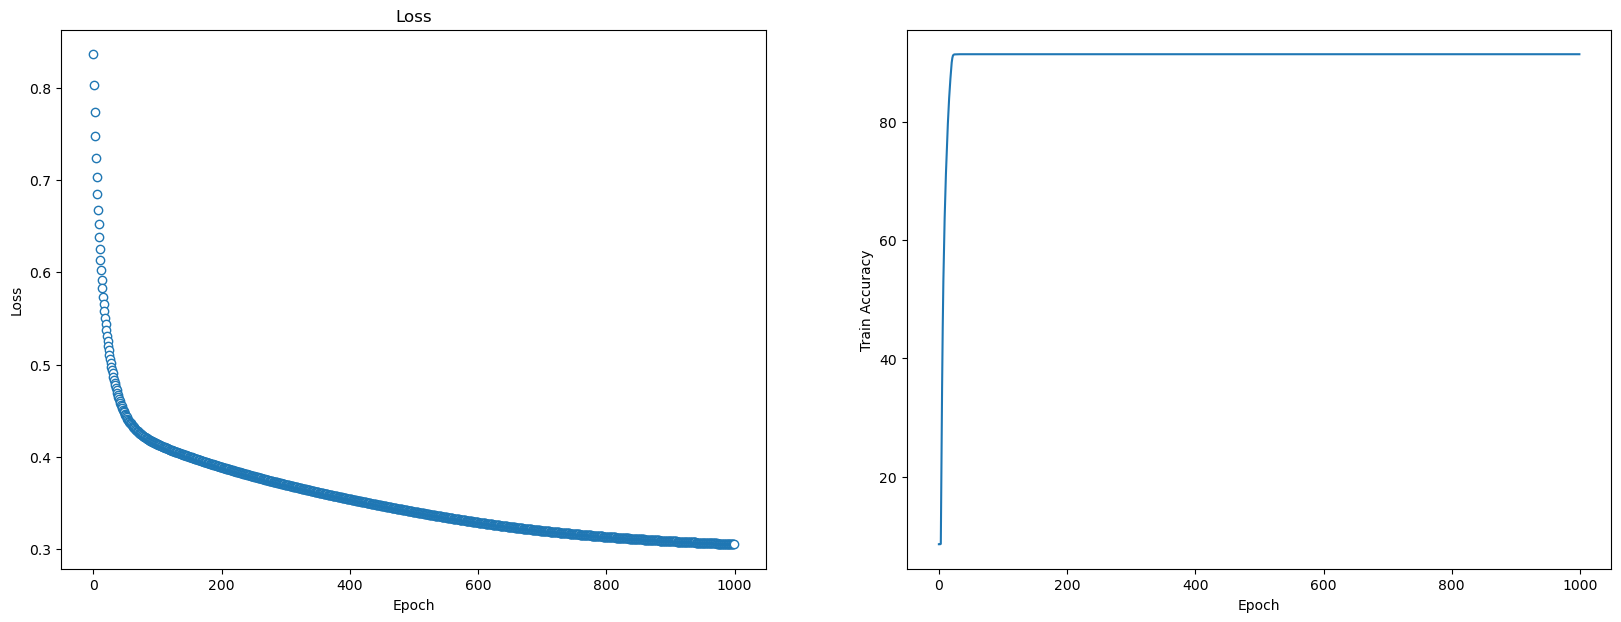

In [86]:
# Experiment with Simple data
pccf_model = PCCFModelSimple()

# run it
losses,predictions,totalacc,trainAcc = trainTheModelSimple(pccf_model)


# plot some results
fig, ax = plt.subplots(1, 2, figsize=(20,7))

ax[0].plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(trainAcc)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Train Accuracy')

# report accuracy
print('Final accuracy: %g%%' %totalacc)


# # show the losses
# plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
# plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

## Training

In [90]:
# # # create and train a model NO BATCHNORM
# model = PCCFModel()
# trainAccNo,testAccNo,lossesNo = trainTheModel(model, doBN=False)


# create and train a model WITH BATCHNORM
model = PCCFModel()
trainAccWith,testAccWith,lossesWith = trainTheModel(model, doBN=True)

## Results

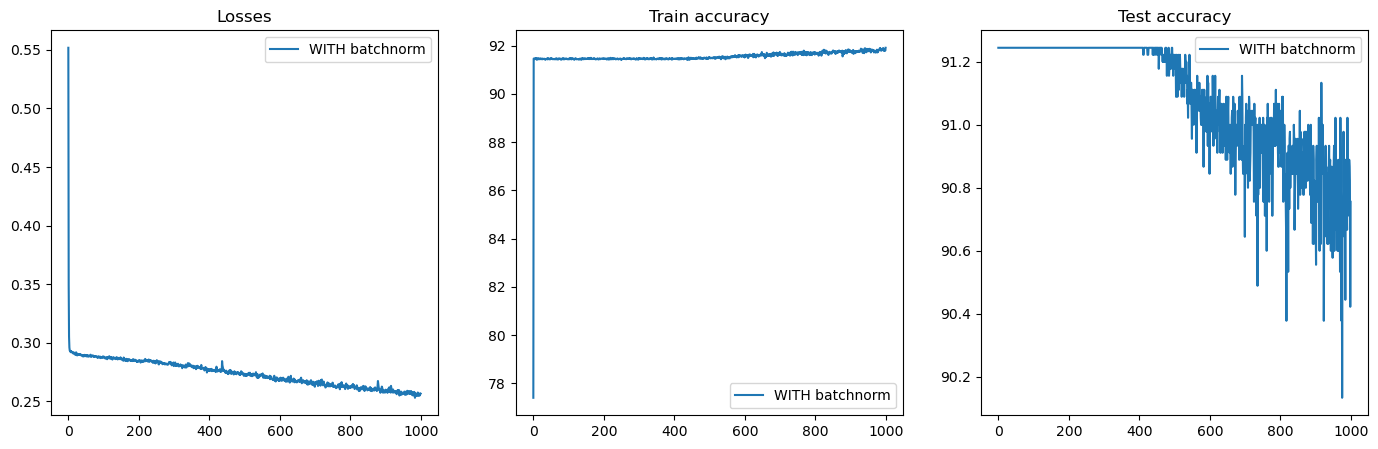

In [91]:
# # plot the results
fig,ax = plt.subplots(1,3,figsize=(17,5))

ax[0].plot(lossesWith,label='WITH batchnorm')
# ax[0].plot(lossesNo,label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAccWith,label='WITH batchnorm')
# ax[1].plot(trainAccNo,label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(testAccWith,label='WITH batchnorm')
# ax[2].plot(testAccNo,label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()